# Social media analytics with pyspark (seharusnya)

This jupyter notebook was used to analyst the sentiment of clean_tweet.csv data, there's a few step of this implementation of sentiment analyst:
1. Importing data
2. Data preprocessing
3. Splitting data
4. Feature extraction
5. Classification
6. Visualization

### Import the library
There's some library that must be used for this analysis. </br>
1. pandas: For importing data and analysis data
2. numpy: used for numerical data
3. nltk
3.1. Stopword corpus: the corpus for data preprocessing
3.2. PorterStemmer: stemming the data at data preprocessing
4. re: regex
5. texblob: text processing
6. pyplot: plot the data with matplotlib
7. seaborn: to plot the data

In [41]:
import pandas as pd 
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

#import reguler expression 
import re

#import textblob 
from textblob import TextBlob

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

#import sklearn for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dzulfi064176\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dzulfi064176\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import the data

The data was containt 2 columns, text and target. Tweet data was stored in text column 'text', and the predicted sentiment class was stored in column target, the 0 represent the negative sentiment, and 1 was the positive sentiment. The dimension of data is (1600000, 2).

In [2]:
df = pd.read_csv('clean_tweet.csv')
print('row x columns in data ',df.shape)
df.head(5)

row x columns in data  (1600000, 2)


,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


The datatype of the data that used in this analysist was object for text column, and int64 for target column.

## Data Preprocessing

### Check the null values

This step was to check the null values, and the result was 3247 null data in text column, and 0 data in target column.

In [4]:
df.isnull().sum()

text      3247
target       0
dtype: int64

## Drop the null value

From the result that we've had in previous step, we drop the row that containt null values for the better performance in the future.

In [5]:
df_drop = df.dropna()
df_drop.shape

(1596753, 2)

### Drop the duplicate data

Beside of the null values, we must pay attention for the duplicate data. We can reduce more data on that duplicates data to improve the performance

In [6]:
df_drop = df_drop.drop_duplicates()
df_drop.shape

(1528140, 2)

After dropping the duplicate data, we reduce the data by 108564 row.

### Stopword removal

In this step, we remove the stopword to reduce the word that not informative for this classification.

In [7]:
%%time

stop = stopwords.words('english')
df_drop['text'] = df_drop['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

Wall time: 49.1 s


In [ ]:
df_drop.head(5)

The word from sentence was reduce, the different in the row 4. Initialy the sentence was ``no it s not behaving at all i m mad why am i h...	``, after using the stopword removal, the sentence become ``behaving mad see``

### Rare words removal

This step was purpose to remove the rare word

In [8]:
rare_word = pd.Series(' '.join(df_drop['text']).split()).value_counts()[-100:]
rare_word

triathelon       1
wilkonsons       1
quicheenfolie    1
abrahams         1
looooveeelyyy    1
                ..
furor            1
atiyas           1
buttershots      1
kuze             1
meiki            1
Length: 100, dtype: int64

In [9]:
%%time

rare_word = list(rare_word.index)
df_drop['text'] = df_drop['text'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))
df_drop['text'].head(5)

Wall time: 22.5 s


### Stemming

This step was used to look up the basic word of the word in the dataset.

In [10]:
%%time

st = PorterStemmer()
df_drop['text'] = df_drop['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

Wall time: 5min 40s


In [ ]:
df_drop.head(5)

## Sentiment Analysis

The purpose of this sentiment are 2 kind, 1 for positive sentiment and 0 for negative sentiment.

## Data Exploration

We want to explore the data first before we go to far to classification.

In [11]:
#count sentiment 
sentiment = df_drop.groupby(['target'])['target'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['target']
chart.drop(['target'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,target,tweet_count,percent
0,0,768347,0.502799
1,1,759793,0.497201


### Barchart

There's a bar chart for tweet count and the sentiment

Text(0.5, 1.0, 'Sentiment Class')

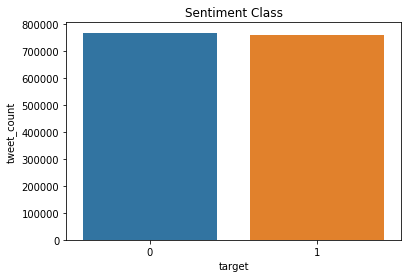

In [12]:
#visualization 
ax = sns.barplot(x= 'target', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

### Wordcloud

From worldcloud, we know the graph of the word that are frequent in the each class.

In [13]:
#define positive and negative 
happy = df_drop.loc[df_drop['target'] == 1]
not_happy  = df_drop.loc[df_drop['target'] == 0]

In [14]:
#merge all the positive comments into one paragraph
all_description_happy = "".join(happy.text.values)
all_description_not_happy = "".join(not_happy.text.values)

In [15]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

**Positive Word Cloud**

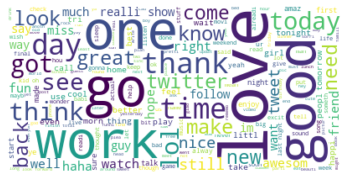

In [16]:
#positive 
create_word_cloud(all_description_happy)

The result above of word cloud was a word that mostly appear in the positive sentiment.

**Negative Word Cloud**

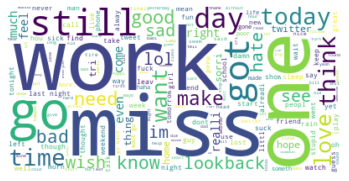

In [17]:
#negative
create_word_cloud(all_description_not_happy)

The result above of word cloud was a word that mostly appear in the negative sentiment.

## Feature Extraction

There some feature extraction that we used in this implementation is:
1. TF-IDF Vectorizer
2. Count Vectorizer
3. Hasing Vectorizer
4. Bigram Vectorizer

The purpose of using more than one feature extraction is to determine what is the best feature extraction for tweet data.

**TF-IDF vectorizer**

In [18]:
tfidf = TfidfVectorizer()

**Count vectorizer**

In [27]:
count_vectorizer = CountVectorizer(stop_words='english')

**Hashing Vectorizer**

In [54]:
hv = HashingVectorizer(alternate_sign=False)

**Bigram Vectorizer**

In [62]:
bigram = CountVectorizer(ngram_range=(2, 2))

## Modeling

### Train Test Split

Split the data into X for data, and y to target. After splitting the data into data and target, then we get the feature for each feature extraction.

In [19]:
X = df_drop['text']
y = df_drop['target']

**TF-IDF Vectorizer**

In [20]:
#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

**Count Vectorizer**

In [34]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

**Hashing Vectorizer**

In [56]:
#hashingvectorizer
X_hv = hv.fit_transform(X)

**Bigram Vectorizer**

In [63]:
#bigramvectorizer
X_bigram = bigram.fit_transform(X)

### Split the Feature

After we get the feature from previous step, we split the data into train and test with ratio 8:2 for every feature we had.

In [35]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

In [21]:
#train val split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

In [57]:
#train val split using hashingvectorizer 
train_X_hv, test_X_hv, train_y, test_y = train_test_split(X_hv, y, test_size=0.2, random_state=0)

In [64]:
#train val split using bigramvectorizer 
train_X_bigram, test_X_bigram, train_y, test_y = train_test_split(X_bigram, y, test_size=0.2, random_state=0)

### Model Machine Learning
a. Logistic regression <br>
b. Naive Bayes <br>

<br>
The model's above are gonna be our method for building the model for our implementation to classifying sentiment the data of tweet that we had.

We build the model and test for each feature, so, there's a 4 model & predict data for logistic regression and 4 model & predict data for Naive Bayes.

**a. Logistic Regression**

In [37]:
# Countvectorizer
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

In [22]:
#TF-IDF
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

In [58]:
#Hashing
Lr_hv = LogisticRegression()
Lr_hv.fit(train_X_hv, train_y)
Lr_pred_hv_train = Lr_hv.predict(train_X_hv)
Lr_pred_hv_test = Lr_hv.predict(test_X_hv)

In [65]:
#Bigram
Lr_bigram = LogisticRegression()
Lr_bigram.fit(train_X_bigram, train_y)
Lr_pred_bigram_train = Lr_bigram.predict(train_X_bigram)
Lr_pred_bigram_test = Lr_bigram.predict(test_X_bigram)

**b. Naive Bayes**

In [36]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [32]:
#TF-IDF
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

In [59]:
#Hashing
NB_hv = MultinomialNB()
NB_hv.fit(train_X_hv, train_y)
NB_pred_hv_train = NB_hv.predict(train_X_hv)
NB_pred_hv_test = NB_hv.predict(test_X_hv)

In [66]:
#Bigram
NB_bigram = MultinomialNB()
NB_bigram.fit(train_X_bigram, train_y)
NB_pred_bigram_train = NB_bigram.predict(train_X_bigram)
NB_pred_bigram_test = NB_bigram.predict(test_X_bigram)

## Model Evaluation
The following option are kind of model evaluation that used for this implementation for evaluate the method we used.

- Precision = precision_score()
- Recall = recall_score()
- F_measure = f1_score()

### Logistic Regression

In [73]:
print("___________________ TF-IDF ____________________")

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_tfidf_test * 100))

print("_______________ Countvectorizer _______________")

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

print("______________ Hashingvectorizer ______________")

Lr_recall_hv_train = recall_score(train_y, Lr_pred_hv_train, average="micro")
Lr_recall_hv_test = recall_score(test_y, Lr_pred_hv_test,average="micro") 

Lr_precision_hv_train = precision_score(train_y, Lr_pred_hv_train,average="micro")
Lr_precision_hv_test = precision_score(test_y, Lr_pred_hv_test,average="micro")

Lr_f1_score_hv_train = f1_score(train_y, Lr_pred_hv_train,average="micro")
Lr_f1_score_hv_test = f1_score(test_y,Lr_pred_hv_test,average="micro")

print('Recall train & test     : %.2f%%' % (Lr_recall_hv_train * 100), '&', '%.2f%%' % (Lr_recall_hv_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_hv_train * 100), '&', '%.2f%%' % (Lr_precision_hv_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_hv_train * 100), '&', '%.2f%%' % (Lr_f1_score_hv_test * 100))

print("____________________ Bigram ___________________")

Lr_recall_bigram_train = recall_score(train_y, Lr_pred_bigram_train, average="micro")
Lr_recall_bigram_test = recall_score(test_y, Lr_pred_bigram_test,average="micro") 

Lr_precision_bigram_train = precision_score(train_y, Lr_pred_bigram_train,average="micro")
Lr_precision_bigram_test = precision_score(test_y, Lr_pred_bigram_test,average="micro")

Lr_f1_score_bigram_train = f1_score(train_y, Lr_pred_bigram_train,average="micro")
Lr_f1_score_bigram_test = f1_score(test_y,Lr_pred_bigram_test,average="micro")

print('Recall train & test     : %.2f%%' % (Lr_recall_bigram_train * 100), '&', '%.2f%%' % (Lr_recall_bigram_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_bigram_train * 100), '&', '%.2f%%' % (Lr_precision_bigram_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_bigram_train * 100), '&', '%.2f%%' % (Lr_f1_score_bigram_test * 100))

___________________ TF-IDF ____________________
Information :
Recall train & test     : 78.98% & 77.02%
Precision train & test  : 78.98% & 77.02%
F1 Score train & test   : 78.98% & 77.02%
_______________ Countvectorizer _______________
Recall train & test     : 79.36% & 76.35%
Precision train & test  : 79.36% & 76.35%
F1 Score train & test   : 79.36% & 76.35%
______________ Hashingvectorizer ______________
Recall train & test     : 78.09% & 76.98%
Precision train & test  : 78.09% & 76.98%
F1 Score train & test   : 78.09% & 76.98%
____________________ Bigram ___________________
Recall train & test     : 94.56% & 72.54%
Precision train & test  : 94.56% & 72.54%
F1 Score train & test   : 94.56% & 72.54%


### Naive Bayes

In [72]:
print("___________________ TF-IDF ____________________")

NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_tfidf_test * 100))

print("_______________ Countvectorizer _______________")

NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

print("______________ Hashingvectorizer ______________")

NB_recall_hv_train = recall_score(train_y, NB_pred_hv_train, average="micro")
NB_recall_hv_test = recall_score(test_y, NB_pred_hv_test,average="micro") 

NB_precision_hv_train = precision_score(train_y, NB_pred_hv_train,average="micro")
NB_precision_hv_test = precision_score(test_y, NB_pred_hv_test,average="micro")

NB_f1_score_hv_train = f1_score(train_y, NB_pred_hv_train,average="micro")
NB_f1_score_hv_test = f1_score(test_y,NB_pred_hv_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_hv_train * 100), '&', '%.2f%%' % (NB_recall_hv_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_hv_train * 100), '&', '%.2f%%' % (NB_precision_hv_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_hv_train * 100), '&', '%.2f%%' % (NB_f1_score_hv_test * 100))

print("____________________ Bigram ___________________")

NB_recall_bigram_train = recall_score(train_y, NB_pred_bigram_train, average="micro")
NB_recall_bigram_test = recall_score(test_y, NB_pred_bigram_test,average="micro") 

NB_precision_bigram_train = precision_score(train_y, NB_pred_bigram_train,average="micro")
NB_precision_bigram_test = precision_score(test_y, NB_pred_bigram_test,average="micro")

NB_f1_score_bigram_train = f1_score(train_y, NB_pred_bigram_train,average="micro")
NB_f1_score_bigram_test = f1_score(test_y,NB_pred_bigram_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_bigram_train * 100), '&', '%.2f%%' % (NB_recall_bigram_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_bigram_train * 100), '&', '%.2f%%' % (NB_precision_bigram_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_bigram_train * 100), '&', '%.2f%%' % (NB_f1_score_bigram_test * 100))

___________________ TF-IDF ___________________
Information :
Recall train & test     : 78.33% & 75.13%
Precision train & test  : 78.33% & 75.13%
F1 Score train & test   : 78.33% & 75.13%
_______________ Countvectorizer _______________
Information :
Recall train & test     : 78.15% & 75.53%
Precision train & test  : 78.15% & 75.53%
F1 Score train & test   : 78.15% & 75.53%
______________ Hashingvectorizer ______________
Information :
Recall train & test     : 77.67% & 76.00%
Precision train & test  : 77.67% & 76.00%
F1 Score train & test   : 77.67% & 76.00%
____________________ Bigram ___________________
Information :
Recall train & test     : 92.16% & 73.09%
Precision train & test  : 92.16% & 73.09%
F1 Score train & test   : 92.16% & 73.09%


### Summary

From the evaluation we had, we can conclude that:
- Hashing vectorizer was good for feature extraction on tweet data.
- From the model above, Naive Bayes was more good compare to Logistic Regression.